## Yahoo Finance Library

In [1]:
import pandas as pd
#!pip install yfinance
#!pip install yahoofinancials
import yfinance as yf

df_yahoo = yf.download(['AAPL','MSFT'], start='2010-01-01', end='2021-12-31', progress=False)

# We can pass a list of multiple tickers, such as ['AAPL', 'MSFT'].
# We can set auto_adjust=True to download only the adjusted prices.
# We can additionally download dividends and stock splits by
# setting actions='inline'.
# Setting progress=False disables the progress bar.

In [2]:
df_yahoo.tail()

Adj Close                   Close                    High  \
                  AAPL        MSFT        AAPL        MSFT        AAPL   
Date                                                                     
2021-12-23  176.055695  333.999390  176.279999  334.690002  176.850006   
2021-12-27  180.100540  341.743378  180.330002  342.450012  180.419998   
2021-12-28  179.061859  340.545837  179.289993  341.250000  181.330002   
2021-12-29  179.151749  341.244415  179.380005  341.950012  180.630005   
2021-12-30  177.973251  338.619843  178.199997  339.320007  180.570007   

                               Low                    Open              \
                  MSFT        AAPL        MSFT        AAPL        MSFT   
Date                                                                     
2021-12-23  336.390015  175.270004  332.730011  175.850006  332.750000   
2021-12-27  342.480011  177.070007  335.429993  177.089996  335.459991   
2021-12-28  343.809998  178.529999  340.320007  180.160004  343.149994   
2021-12-29  344.299988  178.139999  339.679993  179.330002  341.299988   
2021-12-30  343.130005  178.089996  338.820007  179.470001  341.910004   

              Volume            
                AAPL      MSFT  
Date                            
2021-12-23  68356600  19617800  
2021-12-27  74919600  19947000  
2021-12-28  79144300  15661500  
2021-12-29  62348900  15042000  
2021-12-30  59773000  15994500

<AxesSubplot:title={'center':"APPLE's stock price"}, xlabel='Date'>

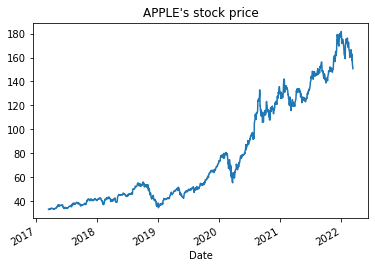

In [3]:
ticker = yf.Ticker('AAPL')
aapl_df = ticker.history(period="5y")
aapl_df['Close'].plot(title="APPLE's stock price")

## Prices to Return

$$R_{i}=\frac{P_{t}-P_{t-1}}{P_{t-1}}=\frac{P_{t}}{P_{t-1}-1}$$
$$Rlog_{i}=log(P_{t}/P_{t-1})=log(P_{t})-log(P_{t-1})$$

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
df = yf.download('AAPL', start='2000-01-01', end='2010-12-31', progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)


In [5]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [6]:
df.tail()

,adj_close,simple_rtn,log_rtn
Date,,,
2010-12-23,9.896083,-0.004798,-0.004809
2010-12-27,9.929112,0.003338,0.003332
2010-12-28,9.953275,0.002433,0.002431
2010-12-29,9.947768,-0.000553,-0.000553
2010-12-30,9.897921,-0.005011,-0.005024


## Realized Volatility

$$\sigma_{t}=\sqrt{\sum_{i=1}^{T}r_{i}^{2}}$$

In [7]:
import pandas as pd
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

In [8]:
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)

In [9]:
df_rv.rv = df_rv.rv * np.sqrt(12)

In [12]:
df_rv.tail()

,adj_close,simple_rtn,rv
Date,,,
2010-08-31,36.066831,0.059837,0.208900
2010-09-30,38.422173,0.066622,0.228470
2010-10-31,42.198494,0.070315,0.241164
2010-11-30,43.672891,0.065022,0.224921
2010-12-31,45.047621,0.026611,0.091787


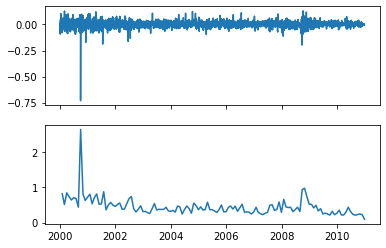

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Log returns (%)')]

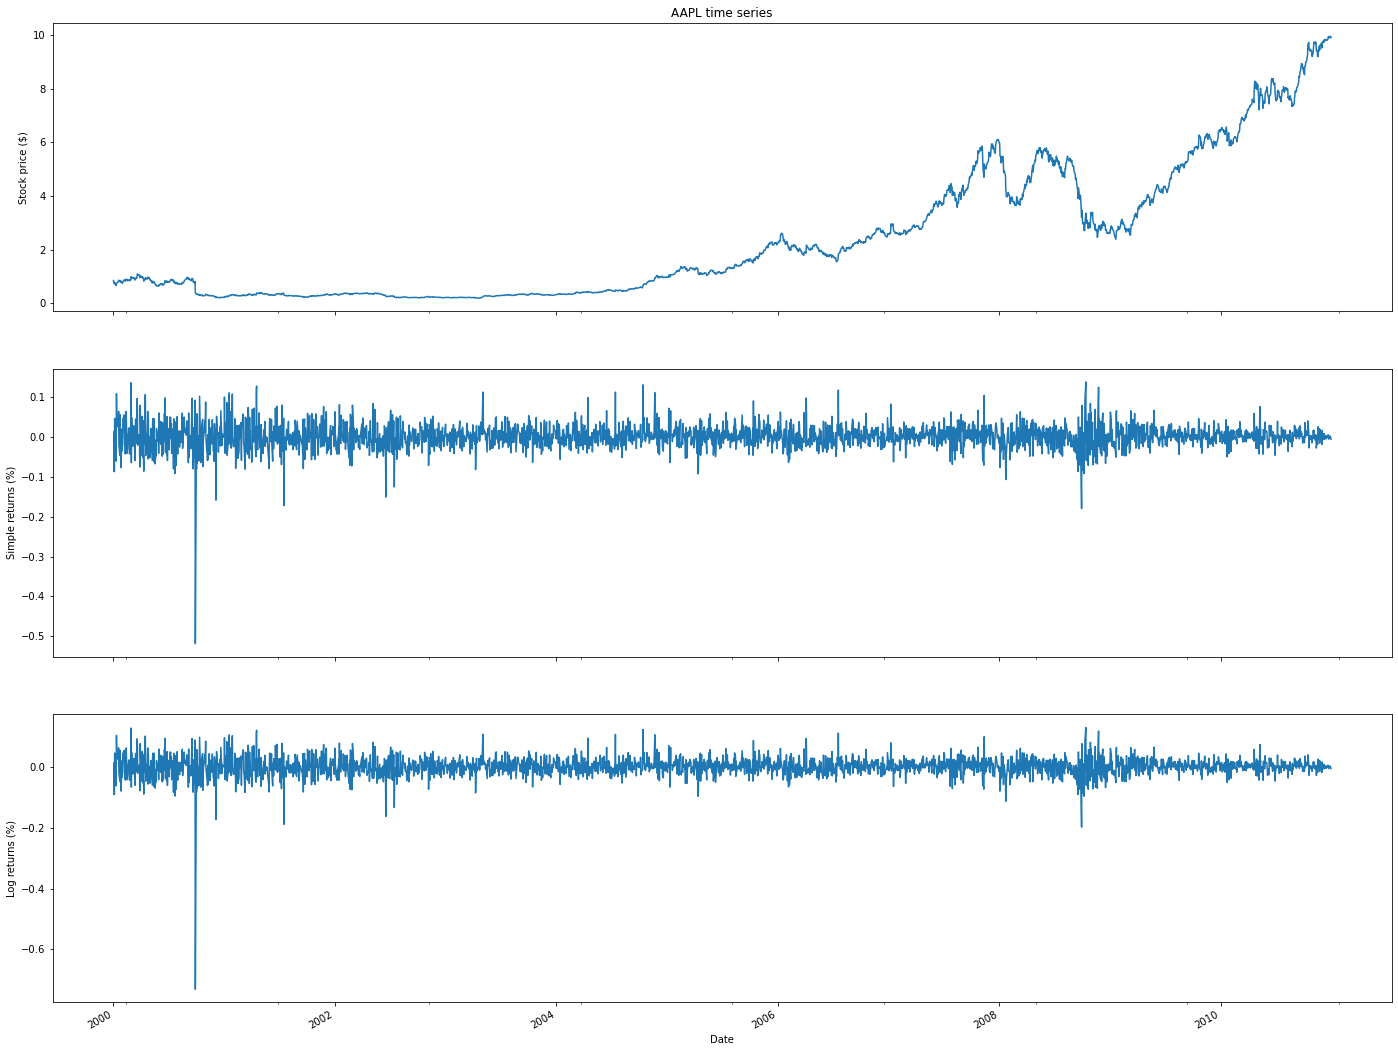

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'AAPL time series',
ylabel = 'Stock price ($)')
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',
ylabel = 'Log returns (%)')

## Outlier Detection

$$Outlier_{low}<\mu-3\cdot \sigma$$
$$Outlier_{high}<\mu+3\cdot \sigma$$

In [15]:
df_rolling = df[['log_rtn']].rolling(window=21) \
.agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [16]:
df_outliers = df.join(df_rolling)

In [18]:
def indentify_outliers(row, n_sigmas=3):
    x = row['log_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma): 
        return 1
    else:
        return 0

In [19]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,['log_rtn']]

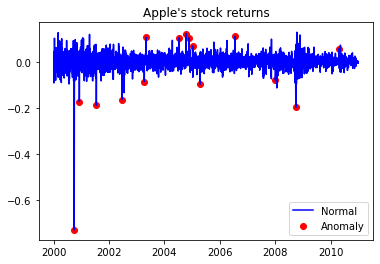

In [22]:
fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.log_rtn,
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.log_rtn,
        color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')